<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/my_object_detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [23]:
from google.colab import drive 
drive.mount('/content/gdrive') 
!ls -la "/content/gdrive/My Drive/colab_data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 8
drwx------ 2 root root 4096 Sep 19 05:26 Mask_RCNN-master
drwx------ 7 root root 4096 Sep 15 19:16 models


In [24]:
%cd "/content/gdrive/My Drive/colab_data/models/research"

/content/gdrive/My Drive/colab_data/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
!pwd

/content/gdrive/My Drive/colab_data/models/research


In [0]:
!rm -rf /content/input \
&& mkdir /content/input \
&& unzip "../../../competition_7/brand-logo-detection-dataset.zip" -d /content/input

Archive:  ../../../competition_7/brand-logo-detection-dataset.zip
   creating: /content/input/brand-logo-detection-dataset/
   creating: /content/input/brand-logo-detection-dataset/trainval_jpg/
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/4652863706.jpg  
   creating: /content/input/__MACOSX/
   creating: /content/input/__MACOSX/brand-logo-detection-dataset/
   creating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4652863706.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/4328758763.jpg  
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4328758763.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/320927855.jpg  
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._320927855.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_j

In [0]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research')
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research/slim')

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [0]:
# from colab.utils import label_map_util
from object_detection.utils import label_map_util, dataset_util
from object_detection.utils import visualization_utils as vis_util

# OWN DATAST

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2019-09-23 10:09:38--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.6’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  64.6MB/s    in 1.1s    

2019-09-23 10:09:40 (64.6 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.6’ saved [76541073/76541073]



In [46]:
import pandas as pd

BASE_DATA_DIR = 'input/brand-logo-detection-dataset/'
df = pd.read_csv(BASE_DATA_DIR + 'trainval_bboxes.txt', header=None)
df.columns = ['image_id','brand_name','x', 'y', 'width', 'height']

brand_list = df['brand_name'].unique()
brand_map = dict()
for (i, brand) in enumerate(brand_list):
    brand_map[brand] = i
df.head()

print(brand_list)

['google' 'apple' 'adidas' 'HP' 'stellaartois' 'paulaner' 'guiness'
 'singha' 'cocacola' 'dhl' 'texaco' 'fosters' 'fedex' 'aldi' 'chimay'
 'shell' 'becks' 'tsingtao' 'ford' 'carlsberg' 'bmw' 'pepsi' 'esso'
 'heineken' 'erdinger' 'corona' 'milka' 'ferrari' 'nvidia' 'rittersport'
 'ups' 'starbucks']


In [0]:
resnet_config = """
model {
  ssd {
    num_classes: 32
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_resnet50_v1_fpn"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.000399999989895
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019
          scale: true
          epsilon: 0.0010000000475
        }
      }
      override_base_feature_extractor_hyperparams: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 0.000399999989895
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.00999999977648
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019
            scale: true
            epsilon: 0.0010000000475
          }
        }
        depth: 256
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.59999990463
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 0.300000011921
        iou_threshold: 0.600000023842
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 32
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.0399999991059
          total_steps: 25000
          warmup_learning_rate: 0.0133330002427
          warmup_steps: 2000
        }
      }
      momentum_optimizer_value: 0.899999976158
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "/content/gdrive/My Drive/colab_data/models/research/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03/model.ckpt"
  num_steps: 25000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}
train_input_reader {
  label_map_path: "/content/gdrive/My Drive/colab_data/models/research/input/brands.proto"
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/colab_data/models/research/input/train_data.record"
  }
}
eval_config {
  num_examples: 8000
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/content/gdrive/My Drive/colab_data/models/research/input/brands.proto"
  shuffle: false
  num_readers: 1
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/colab_data/models/research/input/val_data.record"
  }
}
"""


with open('/content/gdrive/My Drive/colab_data/models/research/input/pipeline_resnet.config', "w+") as f:
    data = f.read()
    f.seek(0)
    f.write(resnet_config)
    f.truncate()

In [0]:
config = """
model {
  ssd {
    num_classes: 32
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v1"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.99999989895e-05
            }
          }
          initializer {
            truncated_normal_initializer {
              mean: 0.0
              stddev: 0.0299999993294
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.999700009823
            center: true
            scale: true
            epsilon: 0.0010000000475
            train: true
          }
        }
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.800000011921
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.20000000298
        max_scale: 0.949999988079
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.333299994469
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 0.300000011921
        iou_threshold: 0.600000023842
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.990000009537
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
  }
}
train_config {
  batch_size: 16
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
  optimizer {
    rms_prop_optimizer {
      learning_rate {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.00400000018999
          decay_steps: 800720
          decay_factor: 0.949999988079
        }
      }
      momentum_optimizer_value: 0.899999976158
      decay: 0.899999976158
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/content/gdrive/My Drive/colab_data/models/research/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  num_steps: 200000
}
train_input_reader {
  label_map_path: "/content/gdrive/My Drive/colab_data/models/research/input/brands.proto"
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/colab_data/models/research/input/train_data.record"
  }
}
eval_config {
  num_examples: 8000
  max_evals: 10
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/content/gdrive/My Drive/colab_data/models/research/input/brands.proto"
  shuffle: false
  num_readers: 1
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/colab_data/models/research/input/val_data.record"
  }
}
"""
with open('/content/gdrive/My Drive/colab_data/models/research/input/pipeline.config', "r+") as f:
    data = f.read()
    f.seek(0)
    f.write(config)
    f.truncate()


In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import cv2

def split_datasets(dataset, val=.1):
    val_dataset = []
    train_dataset = []
    for item in dataset:
        if np.random.rand() <= val:
            val_dataset.append(item)
        else:
            train_dataset.append(item)
    return (train_dataset, val_dataset)

def show_examples(image_ids, cnt_limit):
    fig = plt.figure(figsize=(64, 64))
    cnt = 0
    
    for (_, img_id) in enumerate(image_ids):
        path = BASE_DATA_DIR + 'trainval_jpg/' + img_id
        if os.path.isfile(path) == False:
            continue

        img = cv2.imread(path)
        image_data_items = df[df['image_id'] == img_id]

        fig,ax = plt.subplots(1)
        ax.imshow(img)
        for (i, image_data) in image_data_items.iterrows():
            rect = patches.Rectangle((image_data['x'],image_data['y']),image_data['width'],image_data['height'],linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            plt.text(5, 5, image_data['brand_name'], color='red', fontsize=12)
            plt.text(5, 25, brand_map[image_data['brand_name']] + 1, color='red', fontsize=12)
        plt.show()
        plt.pause(.01)

        cnt += 1
        if cnt >= cnt_limit:
            break

statistics = dict(created=0, skipped=0)
def create_tf_example(image_id):
    image_data = df[df['image_id'] == image_id]
    img_fpath = os.path.join('/content/gdrive/My Drive/colab_data/models/research/input/brand-logo-detection-dataset/trainval_jpg', image_id)
    if os.path.isfile(img_fpath) == False:
        statistics['skipped'] += 1
        return
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(image_id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [] 
    # List of string class name of bounding box (1 per box)
    classes_text = []
    # List of integer class id of bounding box (1 per box)
    classes = []

    for (i, row) in image_data.iterrows():
        xmins.append(row['x'] / float(width))
        ymins.append(row['y'] / float(height))
        xmaxs.append((row['x'] + row['width']) / float(width))
        ymaxs.append((row['y'] + row['height']) / float(height))
        classes_text.append(bytes(row['brand_name'], encoding = 'utf-8'))
        classes.append(brand_map[row['brand_name']] + 1)

    if len(image_data) > 0:
        statistics['created'] += 1
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [0]:
# This is needed to display the images.
%matplotlib inline

<Figure size 4608x4608 with 0 Axes>

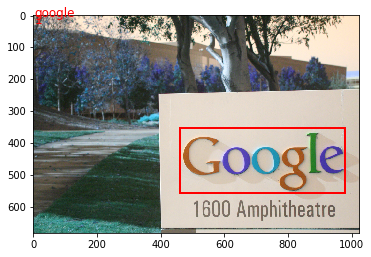

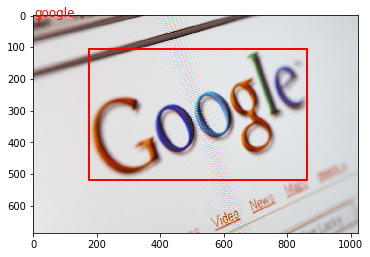

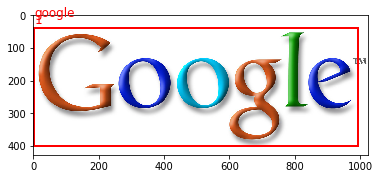

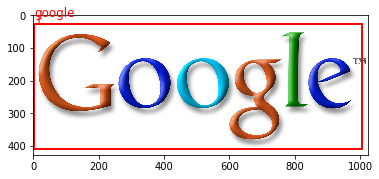

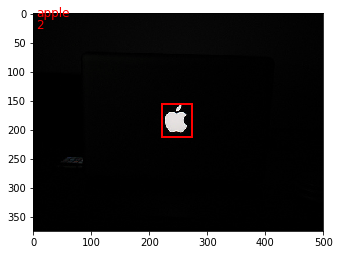

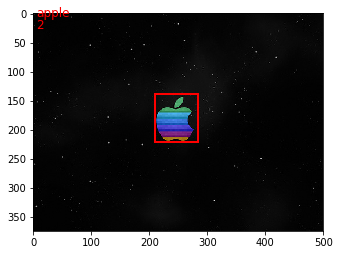

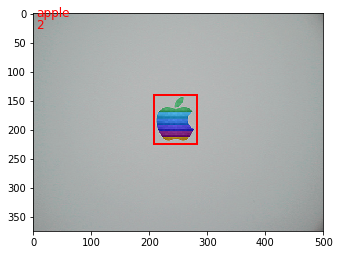

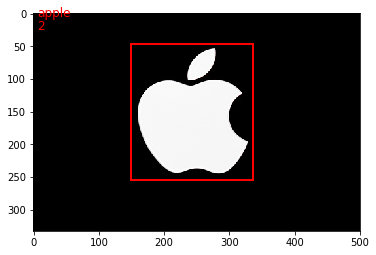

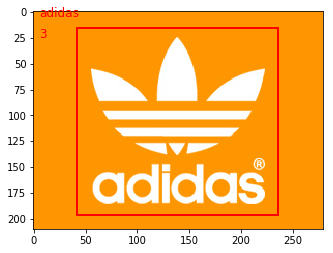

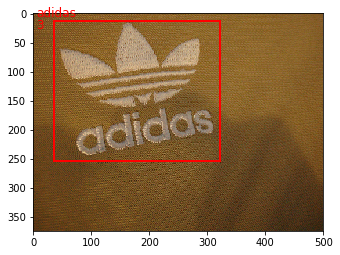

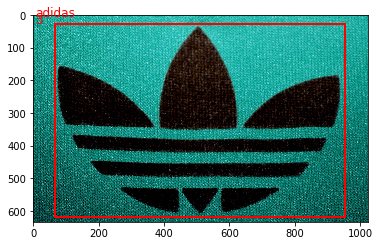

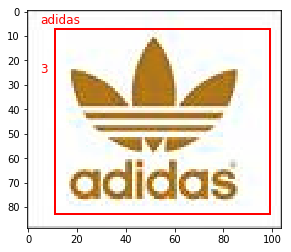

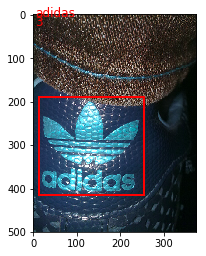

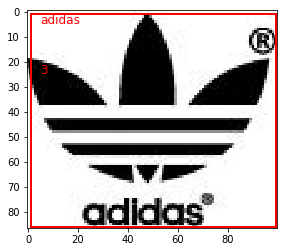

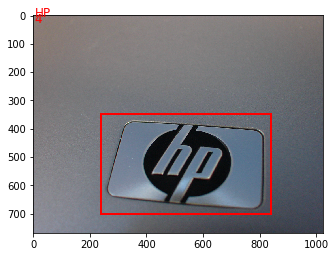

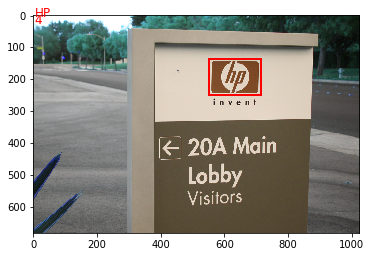

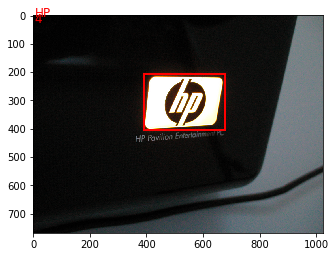

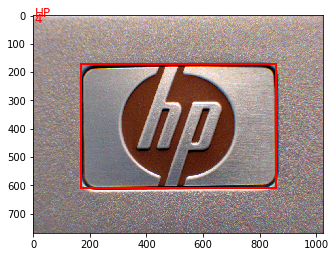

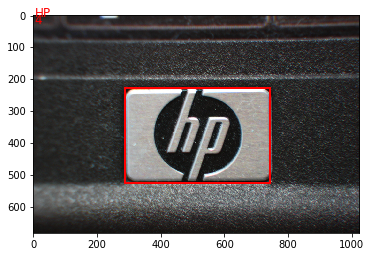

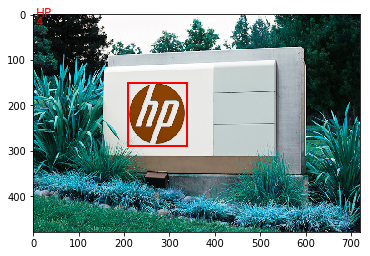

In [0]:
show_examples(df['image_id'].unique(), 20)

In [31]:
train_images, val_images = split_datasets(df['image_id'].unique())
(len(train_images), len(val_images))

(1137, 143)

In [32]:
!rm -f "/content/gdrive/My Drive/colab_data/models/research/input/train_data.record"
!rm -f "/content/gdrive/My Drive/colab_data/models/research/input/val_data.record"

train_writer = tf.python_io.TFRecordWriter('/content/gdrive/My Drive/colab_data/models/research/input/train_data.record')
for image_id in train_images:
    tf_example = create_tf_example(image_id)
    if tf_example is None:
        continue
    train_writer.write(tf_example.SerializeToString())
train_writer.close()

print(statistics)

val_writer = tf.python_io.TFRecordWriter('/content/gdrive/My Drive/colab_data/models/research/input/val_data.record')
for image_id in val_images:
    tf_example = create_tf_example(image_id)
    if tf_example is None:
        continue
    val_writer.write(tf_example.SerializeToString())
val_writer.close()

{'created': 736, 'skipped': 401}


In [0]:
!pwd

/content/gdrive/My Drive/colab_data/models/research


In [0]:
# !rm -rf my_output
# !export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/model_main.py \
#     --pipeline_config_path=/content/gdrive/My\ Drive/colab_data/models/research/input/pipeline.config \
#     --model_dir=my_output \
#     --num_train_steps=20000 \
#     --alsologtostderr

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0923 10:15:40.023015 140631894267776 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0923 10:15:40.031538 140631894267776 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0923 10:15:40.031946 140631894267776 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W0923 10:15:40.032102

In [33]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/gdrive/My\ Drive/colab_data/models/research/input/pipeline.config \
    --trained_checkpoint_prefix=my_output/model.ckpt-20000 \
    --output_directory=my_output/frozen/





W0923 17:01:43.707120 139916107921280 deprecation_wrapper.py:119] From object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0923 17:01:43.715323 139916107921280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0923 17:01:43.717438 139916107921280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0923 17:01:43.757591 139916107921280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/core/preprocessor.py:2660: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0923 17:01:43.792732 139916107921280 deprecation_wrapper.py:

In [0]:
PATH_TO_FROZEN_GRAPH = '/content/gdrive/My Drive/colab_data/models/research/my_output/frozen/frozen_inference_graph.pb'
PATH_TO_LABELS = '/content/gdrive/My Drive/colab_data/models/research/input/brands.proto'

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [35]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)


{1: {'id': 1, 'name': 'google'}, 2: {'id': 2, 'name': 'apple'}, 3: {'id': 3, 'name': 'adidas'}, 4: {'id': 4, 'name': 'HP'}, 5: {'id': 5, 'name': 'stellaartois'}, 6: {'id': 6, 'name': 'paulaner'}, 7: {'id': 7, 'name': 'guiness'}, 8: {'id': 8, 'name': 'singha'}, 9: {'id': 9, 'name': 'cocacola'}, 10: {'id': 10, 'name': 'dhl'}, 11: {'id': 11, 'name': 'texaco'}, 12: {'id': 12, 'name': 'fosters'}, 13: {'id': 13, 'name': 'fedex'}, 14: {'id': 14, 'name': 'aldi'}, 15: {'id': 15, 'name': 'chimay'}, 16: {'id': 16, 'name': 'shell'}, 17: {'id': 17, 'name': 'becks'}, 18: {'id': 18, 'name': 'tsingtao'}, 19: {'id': 19, 'name': 'ford'}, 20: {'id': 20, 'name': 'carlsberg'}, 21: {'id': 21, 'name': 'bmw'}, 22: {'id': 22, 'name': 'pepsi'}, 23: {'id': 23, 'name': 'esso'}, 24: {'id': 24, 'name': 'heineken'}, 25: {'id': 25, 'name': 'erdinger'}, 26: {'id': 26, 'name': 'corona'}, 27: {'id': 27, 'name': 'milka'}, 28: {'id': 28, 'name': 'ferrari'}, 29: {'id': 29, 'name': 'nvidia'}, 30: {'id': 30, 'name': 'ritter

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [74]:
import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(10)

def howmany_within_range(x, y):
    print(1)
    return x + y

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(4, 8)) for row in data]
pool.close()

print(results)


1
1
1
1
1
1
1
1
[12, 12, 12, 12, 12, 12, 12, 12]


In [2]:
from tqdm import tqdm
import multiprocessing as mp

pool = mp.Pool(10)

IMAGE_SIZE = (12, 8)
THRESHOLD = .7

result = []
TEST_IMAGE_DIR = '/content/input/brand-logo-detection-dataset/test_jpg'
view_limit = 30

def predict_image(test_img):
    img_path = os.path.join(TEST_IMAGE_DIR, test_img)
    image = Image.open(img_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    width, height = image.size
    return output_dict

buffer = []
test_imgs = os.listdir(TEST_IMAGE_DIR)
for (i, test_img) in enumerate(tqdm(test_imgs)):
    buffer.append(test_img)
    print(11)
    if i < len(test_imgs) - 1 and len(buffer) % 10 != 0:
        continue
    
    print(buffer)
    break
    results = [pool.apply(predict_image, args=(buf_img)) for buf_img in buffer]

    for output_dict in results:
        for (i, score) in enumerate(output_dict['detection_scores']):
            if score >= THRESHOLD:
                if output_dict['detection_boxes'][i][3] > .8 or output_dict['detection_boxes'][i][2] > .8:
                    continue
                boxe_scores += 1
                x = int(output_dict['detection_boxes'][i][1] * width)
                y = int(output_dict['detection_boxes'][i][0] * height)
                x2 = int(output_dict['detection_boxes'][i][3] * width)
                y2 = int(output_dict['detection_boxes'][i][2] * height)
                box_width = x2 - x
                box_height = y2 - y
                result_str = ','.join([
                    test_img, 
                    brand_list[output_dict['detection_classes'][i] - 1], 
                    str(score),
                    str(x), str(y),
                    str(box_width), str(box_height),
                ])
                result.append(result_str)
    break
    # if boxe_scores > 0 and view_limit > 0:
    #     view_limit -= 1
    #     vis_util.visualize_boxes_and_labels_on_image_array(
    #         image_np,
    #         output_dict['detection_boxes'],
    #         output_dict['detection_classes'],
    #         output_dict['detection_scores'],
    #         category_index,
    #         instance_masks=output_dict.get('detection_masks'),
    #         use_normalized_coordinates=True,
    #         line_thickness=8,
    #         min_score_thresh=THRESHOLD)
    #     plt.figure(figsize=IMAGE_SIZE)
    #     plt.imshow(image_np)

pool.close()
print(';'.join(result))

NameError: ignored

In [0]:
IMAGE_SIZE = (12, 8)
TEST_IMAGE_DIR = '/content/input/brand-logo-detection-dataset/test_jpg'
for test_img in os.listdir(TEST_IMAGE_DIR):
    img_path = os.path.join(TEST_IMAGE_DIR, test_img)
    //todo
    image = Image.open(img_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh=.3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

output_dict['detection_scores']

# Model RUN

## Env setup

## Object detection imports
Here are the imports from the object detection module.

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection', 'data', 'mscoco_label_map.pbtxt')

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [0]:
image = Image.open(PATH_TO_TEST_IMAGES_DIR + '/image1.jpg')
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
plt.pause(.01)

In [0]:
output_dict.keys()

In [0]:
output_dict['num_detections']

In [0]:
output_dict['detection_boxes'].shape

In [0]:
output_dict['detection_boxes'][1]

In [0]:
output_dict['detection_scores']

In [0]:
output_dict['detection_classes']